In [1]:
# Importing the necessary libraries for the project. 
import pandas as pd 
import yfinance as yf
import numpy as np # for numerical operations
import seaborn as sns #visualisation
import matplotlib.pyplot as plt # visualization
%matplotlib inline 
import matplotlib.ticker as ticker # Library to customize ticks
from datetime import date
import matplotlib.dates as mdates
from scipy import stats
import statsmodels.api as sm
from scipy.stats import shapiro
from statsmodels.tsa.stattools import adfuller, kpss
from statsmodels.tsa.seasonal import MSTL # Multiple Seasonal decompose.
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf # ACF and PACF plots.
from math import sqrt
from statsmodels.tsa.holtwinters import ExponentialSmoothing 
from statsmodels.stats.outliers_influence import variance_inflation_factor # Calculates Variance Inflation Factor to detect multicollinearity.
# ParameterSampler for randomized hyperparameter sampling, optimizing model parameters in cross-validation.
from sklearn.model_selection import ParameterSampler
# pmdarima's auto_arima for automated selection of the best ARIMA parameters based on AIC/BIC scores.
from pmdarima import auto_arima
# Mean Squared Error and Mean Absolute Error metrics from sklearn for evaluating model accuracy.
from sklearn.metrics import mean_squared_error, mean_absolute_error
# TimeSeriesSplit for cross-validation with time series data to preserve the temporal ordering of data.
from sklearn.model_selection import TimeSeriesSplit, ParameterGrid
from statsmodels.tsa.statespace.sarimax import SARIMAX

import warnings # filter warnings
warnings.filterwarnings('ignore')

# Data Collection

In [3]:
# Define ticker symbol and fetch weekly data
ticker_symbol = "^GSPC"
data = yf.download(ticker_symbol, start="2004-01-01", end="2023-12-31", interval="1wk")
display(data)

[*********************100%%**********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2004-01-01,1111.920044,1126.329956,1105.079956,1126.329956,1126.329956,5930800000
2004-01-08,1126.329956,1131.920044,1115.189941,1130.520020,1130.520020,8209800000
2004-01-15,1130.520020,1149.209961,1124.540039,1147.619995,1147.619995,6871900000
2004-01-22,1147.619995,1155.380005,1126.500000,1128.479980,1128.479980,8250600000
2004-01-29,1128.479980,1142.449951,1122.380005,1126.520020,1126.520020,8267800000
...,...,...,...,...,...,...
2023-11-30,4554.870117,4599.390137,4537.240234,4549.339844,4549.339844,22321960000
2023-12-07,4568.839844,4709.689941,4565.220215,4707.089844,4707.089844,20221130000
2023-12-14,4721.040039,4778.009766,4694.339844,4698.350098,4698.350098,26821650000


# Data Preparation same as 90-10 ratio split

In [5]:
df = data.drop(['Open', 'High', 'Low', 'Adj Close', 'Volume'], axis=1) # Drop columns.

In [6]:
# Check the frequency of the time series.
frequency = pd.infer_freq(df.index)

print("Frequency of the time series:", frequency) # Prints the frequency of the series.

Frequency of the time series: W-THU


In [7]:
# Apply log transformation.
log = np.log(df['Close']) 

# First-order differencing to remove trend.
log_diff = log.diff().dropna()

In [8]:
# Calculate the 1st and 99th percentiles.
lower_limit = np.percentile(log_diff, 1)
upper_limit = np.percentile(log_diff, 99)

# Apply winsorization by clipping the values.
log_diff_winso = np.clip(log_diff, lower_limit, upper_limit)

# If you want to work with Pandas.
log_diff_winso = pd.Series(log_diff_winso)

## Testing Baseline Model (SARIMAX) with 90-10 split ratio 

- The ratio for train and test for this project is 80-20

**Note**: Different ratios can be tested in this stage to check what ratio culd yield the best performance.

In [11]:
# 85-15 train-test split
# Determine the split indices
train_size = int(0.90 * len(log_diff_winso))
test_size = int(0.10 * len(log_diff_winso))

# Create train, and test sets
train = log_diff_winso[:train_size]
test = log_diff_winso[train_size:]
print("Training set size:", len(train))
print("Test set size:", len(test))

Training set size: 938
Test set size: 105


The workflow of SARIMA will follow: 
1. Random parameter: Random values, starting point for hyper-parameter tunning.

2. Hyper-parameter tunning: Auto-arima and Random Search. The first will search through combinations that has the lower AIC value and the second will be performed along with cross validation techniques searching for the best RMSE.

3. Cross-Validation: Time-Series and Fixed Rolling Window.

4. Residuals: The analysis will be performed on the best model.   

**The evaluation of results and performance of each model will be at the end, when all models have being applied along with cross-validation techniques**. 

- Performing auto-arima to find optimal parameters using two different frequencies monthly and quaterly. The approach can be a starting point to generate optimal parameters, using the AIC to return the best orders.

**Note**: Rationales for hyperparameter tunning and cross-validation will be written in the present notebook only in order to avoid repetion.

### Six Months Frequency (m=26 weeks)

In [14]:
# Auto-ARIMA with seasonal component
auto_model = auto_arima(train, seasonal=True, m=26, 
                        max_p=3, max_d=1, max_q=3,   # Limits on (p, d, q)
                        max_P=2, max_D=1, max_Q=2,  # Limits on (P, D, Q)
                        stepwise=True,               # Uses a stepwise search
                        trace=True, random_state=42)                  # Display progress

print(auto_model.summary())

Performing stepwise search to minimize aic
 ARIMA(2,0,2)(1,0,1)[26] intercept   : AIC=inf, Time=5.46 sec
 ARIMA(0,0,0)(0,0,0)[26] intercept   : AIC=-4667.623, Time=0.13 sec
 ARIMA(1,0,0)(1,0,0)[26] intercept   : AIC=-4667.494, Time=1.60 sec
 ARIMA(0,0,1)(0,0,1)[26] intercept   : AIC=-4667.754, Time=1.95 sec
 ARIMA(0,0,0)(0,0,0)[26]             : AIC=-4662.848, Time=0.10 sec
 ARIMA(0,0,1)(0,0,0)[26] intercept   : AIC=-4669.648, Time=0.11 sec
 ARIMA(0,0,1)(1,0,0)[26] intercept   : AIC=-4667.745, Time=1.42 sec
 ARIMA(0,0,1)(1,0,1)[26] intercept   : AIC=-4665.991, Time=1.01 sec
 ARIMA(1,0,1)(0,0,0)[26] intercept   : AIC=-4667.880, Time=0.23 sec
 ARIMA(0,0,2)(0,0,0)[26] intercept   : AIC=-4667.926, Time=0.14 sec
 ARIMA(1,0,0)(0,0,0)[26] intercept   : AIC=-4669.495, Time=0.14 sec
 ARIMA(1,0,2)(0,0,0)[26] intercept   : AIC=-4664.643, Time=0.51 sec
 ARIMA(0,0,1)(0,0,0)[26]             : AIC=-4663.930, Time=0.12 sec

Best model:  ARIMA(0,0,1)(0,0,0)[26] intercept
Total fit time: 12.975 seconds


                               SARIMAX Results                                
Dep. Variable:                  Close   No. Observations:                  938
Model:               SARIMAX(0, 0, 1)   Log Likelihood                2333.965
Date:                Mon, 18 Nov 2024   AIC                          -4663.930
Time:                        12:54:45   BIC                          -4654.243
Sample:                    01-08-2004   HQIC                         -4660.237
                         - 12-23-2021                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.0567      0.024     -2.352      0.019      -0.104      -0.009
sigma2         0.0004   1.41e-05     28.671      0.000       0.000       0.000
Ljung-Box (L1) (Q):                   0.07   Jarque-

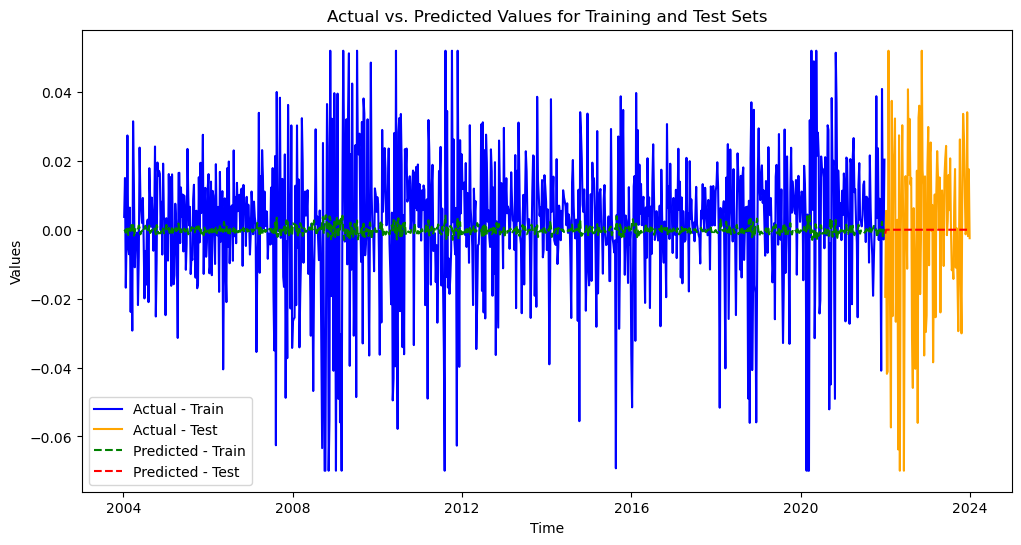

In [15]:
# Define SARIMAX model. 
sarimax_model = SARIMAX(train, order=(0, 0, 1), seasonal_order=(0, 0, 0, 26))
sarimax_final_fitted = sarimax_model.fit(disp=False)

# Print summary.
print(sarimax_final_fitted.summary())

# Calculate RMSE on training data.
train_predictions = sarimax_final_fitted.predict(start=0, end=len(train)-1)
train_rmse = mean_squared_error(train, train_predictions, squared=False)

# Calculate MAE on training data.
train_mae = mean_absolute_error(train, train_predictions)

# Calculate RMSE on test data.
test_predictions = sarimax_final_fitted.forecast(steps=len(test))
test_rmse = mean_squared_error(test, test_predictions, squared=False)

# Calculate MAE on test data.
test_mae = mean_absolute_error(test, test_predictions)

# Calculate Directional Accuracy on Training Data.
train_direction_accuracy = np.mean(
    np.sign(train_predictions[:-1] - train_predictions[1:]) == np.sign(train[:-1] - train[1:]))

# Calculate Directional Accuracy on Test Data.
test_direction_accuracy = np.mean(
    np.sign(test_predictions[:-1] - test_predictions[1:]) == np.sign(test[:-1] - test[1:]))

# Print evaluation metrics.
print(f"Training RMSE: {train_rmse}")
print(f"Test RMSE: {test_rmse}")
print(f"Training MAE: {train_mae}")
print(f"Test MAE: {test_mae}")
print(f"Directional Accuracy on Training Data: {train_direction_accuracy * 100:.2f}%")
print(f"Directional Accuracy on Test Data: {test_direction_accuracy * 100:.2f}%")

# Plot the actual vs. predicted values for training and test sets.
plt.figure(figsize=(12, 6))
plt.plot(train.index, train, label="Actual - Train", color='blue')
plt.plot(test.index, test, label="Actual - Test", color='orange')

# Plot predictions on training and test set.
plt.plot(train.index, train_predictions, label="Predicted - Train", linestyle='--', color='green')
plt.plot(test.index, test_predictions, label="Predicted - Test", linestyle='--', color='red')

# Finalize the plot.
plt.legend()
plt.title("Actual vs. Predicted Values for Training and Test Sets")
plt.xlabel("Time")
plt.ylabel("Values")
plt.show()

#### Random Search with Cross-Validation Technique.

- With different types of hyper-parameter tunning, the random search will be selected to to find the optimal parameters (30 different). The selection is due to the trade-off between range of values and computational resources (takes too long to run). In addition, a random state will be added to ensure reproducibility (same results).
- Grid Search was attempted but it was extremely computational expensive.
- Instead of applying the random search on a simple train and test fold, the approach will be performed along with cross validation (CV), providing a more reliable RMSE across differend folds. 

By performing CV on the parameters generated by the random search, it will also validate if the model performs well.

##### Time-Series Cross-Validation (TSCV) 



In [17]:
# Defines the train-test split indices for time-series cross-validation.
n_splits = 4
test_window = 50  # Number of rows for each test set.
initial_train_window = len(train) - n_splits * test_window

# Parameter grid and random sampling as defined in your prompt
param_grid = {
    'p': [0, 1, 2, 3],
    'd': [0, 1],
    'q': [0, 1, 2, 3],
    'P': [0, 1, 2],
    'D': [0, 1],
    'Q': [0, 1, 2],
    'm': [26]
}

# Number of combinations to try.
n_iter_search = 30  # Number of random parameter combinations.
# Creates a list of the parameters tested and random_state is being called to reproduce same combinations. 
random_param_list = list(ParameterSampler(param_grid, n_iter_search, random_state=42)) 

# Function to evaluate SARIMA with cross-validation.
def evaluate_sarima_cv_rmse(params): # Defining params (p,q,d) and seasonal (p,q,d,m).
    """
    Performs rolling cross-validation on SARIMA model with specified parameters and returns average RMSE.
    """
    p, d, q = params['p'], params['d'], params['q']
    P, D, Q, m = params['P'], params['D'], params['Q'], params['m']
    
    rmse_scores = []  # Stores RMSE for each fold.
    
    for i in range(n_splits):
        # Defines the train and test indices for this fold.
        train_end = initial_train_window + i * test_window
        test_end = train_end + test_window
        
        y_train, y_test = train[:train_end], train[train_end:test_end]
        
        try:
            # Fit SARIMA model on the current training set.
            model = sm.tsa.statespace.SARIMAX(y_train,
                                              order=(p, d, q),
                                              seasonal_order=(P, D, Q, m),
                                              enforce_stationarity=False,
                                              enforce_invertibility=False)
            result = model.fit(disp=False)

            # Forecast on the current test set (one-step ahead only).
            forecast = result.predict(start=len(y_train), end=len(y_train) + len(y_test) - 1)
            
            # Calculate RMSE for this fold.
            rmse = mean_squared_error(y_test, forecast, squared=False)
            rmse_scores.append(rmse)
        except Exception as e:
            print(f"Failed to fit model for parameters {params} on fold {i+1}: {e}")
            return np.inf  # Return large RMSE if fitting fails for this parameter set.
    
    # Calculate the average RMSE across all folds.
    avg_rmse = np.mean(rmse_scores)
    return avg_rmse

# Initialize variables to store the best parameters and lowest average RMSE.
best_rmse = np.inf
best_params = None

# Perform random search with cross-validation.
for params in random_param_list:
    print(f"Testing SARIMA parameters: {params}") # Prints the parameters tested.
    
    # Evaluate SARIMA model with cross-validation.
    rmse = evaluate_sarima_cv_rmse(params)
    
    # Track the best performing parameters and RMSE.
    if rmse < best_rmse:
        best_rmse = rmse
        best_params = params

    print(f"Average RMSE across folds: {rmse}") # Prints the RMSE avg of each combinations.

# Output the best parameters and the best RMSE score.
print(f"Best parameters: {best_params}") # Returns the best combinations among the 30 attempts.
print(f"Best average RMSE across folds: {best_rmse}") # Returns the best avg RMSE among the 30 attempts.

Testing SARIMA parameters: {'q': 2, 'p': 2, 'm': 26, 'd': 0, 'Q': 1, 'P': 2, 'D': 0}
Average RMSE across folds: 0.021011771377398916
Testing SARIMA parameters: {'q': 2, 'p': 1, 'm': 26, 'd': 1, 'Q': 0, 'P': 1, 'D': 0}
Average RMSE across folds: 0.020695167070858
Testing SARIMA parameters: {'q': 2, 'p': 2, 'm': 26, 'd': 1, 'Q': 1, 'P': 0, 'D': 1}
Average RMSE across folds: 0.020734917843637617
Testing SARIMA parameters: {'q': 2, 'p': 0, 'm': 26, 'd': 1, 'Q': 0, 'P': 2, 'D': 1}
Average RMSE across folds: 0.024584675609354328
Testing SARIMA parameters: {'q': 2, 'p': 0, 'm': 26, 'd': 1, 'Q': 0, 'P': 1, 'D': 1}
Average RMSE across folds: 0.026972356275083688
Testing SARIMA parameters: {'q': 0, 'p': 0, 'm': 26, 'd': 1, 'Q': 0, 'P': 1, 'D': 1}
Average RMSE across folds: 0.029026248971445394
Testing SARIMA parameters: {'q': 3, 'p': 0, 'm': 26, 'd': 0, 'Q': 2, 'P': 2, 'D': 0}
Average RMSE across folds: 0.021005440843325434
Testing SARIMA parameters: {'q': 1, 'p': 3, 'm': 26, 'd': 1, 'Q': 0, 'P'

                               SARIMAX Results                                
Dep. Variable:                  Close   No. Observations:                  938
Model:               SARIMAX(3, 1, 1)   Log Likelihood                2331.968
Date:                Mon, 18 Nov 2024   AIC                          -4653.935
Time:                        14:35:04   BIC                          -4629.722
Sample:                    01-08-2004   HQIC                         -4644.703
                         - 12-23-2021                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.0671      0.024     -2.741      0.006      -0.115      -0.019
ar.L2         -0.0234      0.024     -0.957      0.339      -0.071       0.025
ar.L3          0.0081      0.025      0.327      0.7

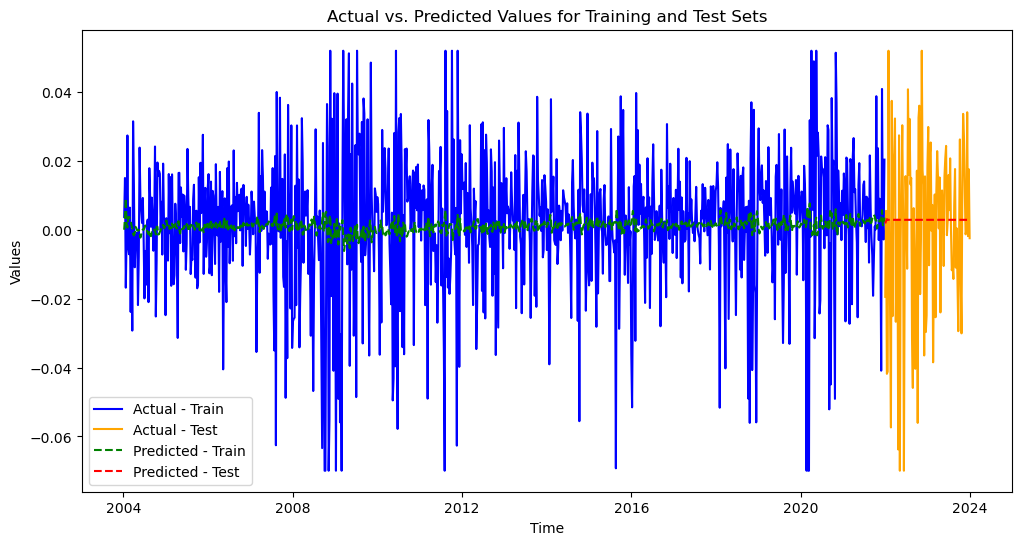

In [18]:
# Time-Series CV.
## Define SARIMAX model.
sarimax_model = SARIMAX(train, order=(3, 1, 1), seasonal_order=(0, 0, 0, 26))
sarimax_final_fitted = sarimax_model.fit(disp=False)

# Print summary.
print(sarimax_final_fitted.summary())

# Calculate RMSE on training data.
train_predictions = sarimax_final_fitted.predict(start=0, end=len(train)-1)
train_rmse = mean_squared_error(train, train_predictions, squared=False)

# Calculate MAE on training data.
train_mae = mean_absolute_error(train, train_predictions)

# Calculate RMSE on test data.
test_predictions = sarimax_final_fitted.forecast(steps=len(test))
test_rmse = mean_squared_error(test, test_predictions, squared=False)

# Calculate MAE on test data.
test_mae = mean_absolute_error(test, test_predictions)

# Calculate Directional Accuracy on Training Data.
train_direction_accuracy = np.mean(
    np.sign(train_predictions[:-1] - train_predictions[1:]) == np.sign(train[:-1] - train[1:]))

# Calculate Directional Accuracy on Test Data.
test_direction_accuracy = np.mean(
    np.sign(test_predictions[:-1] - test_predictions[1:]) == np.sign(test[:-1] - test[1:]))

# Print evaluation metrics.
print(f"Training RMSE: {train_rmse}")
print(f"Test RMSE: {test_rmse}")
print(f"Training MAE: {train_mae}")
print(f"Test MAE: {test_mae}")
print(f"Directional Accuracy on Training Data: {train_direction_accuracy * 100:.2f}%")
print(f"Directional Accuracy on Test Data: {test_direction_accuracy * 100:.2f}%")

# Plot the actual vs. predicted values for training and test sets.
plt.figure(figsize=(12, 6))
plt.plot(train.index, train, label="Actual - Train", color='blue')
plt.plot(test.index, test, label="Actual - Test", color='orange')

# Plot predictions on training and test set.
plt.plot(train.index, train_predictions, label="Predicted - Train", linestyle='--', color='green')
plt.plot(test.index, test_predictions, label="Predicted - Test", linestyle='--', color='red')

# Finalize the plot.
plt.legend()
plt.title("Actual vs. Predicted Values for Training and Test Sets")
plt.xlabel("Time")
plt.ylabel("Values")
plt.show()

4 week (one month) Horizon RMSE: 0.025370878721454836
4 week (one month) Horizon MAE: 0.019725992820864405
4 week (one month) Horizon Directional Accuracy: 92.38%


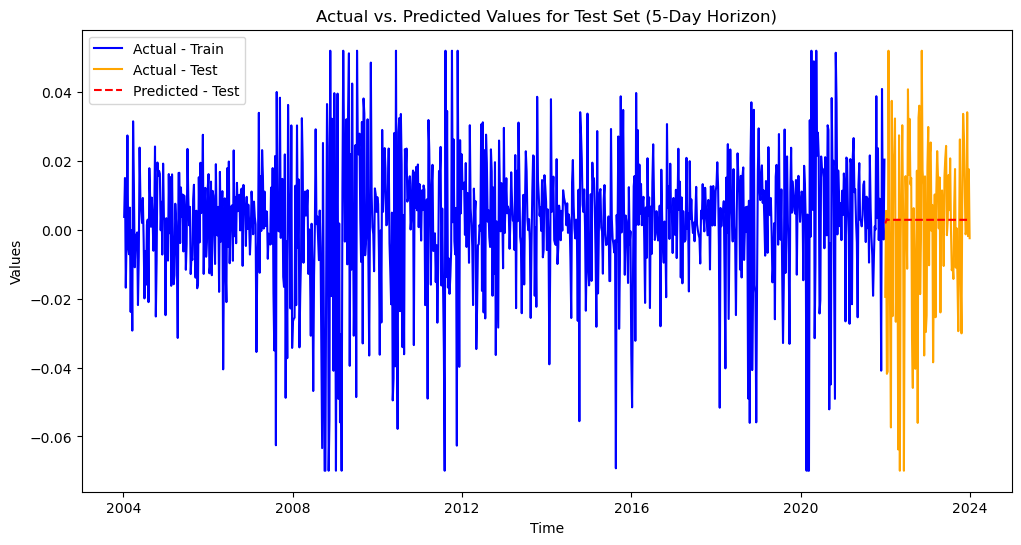

In [19]:
# Define a 4 week (one month) horizon for evaluation metrics.
horizon = 4

# Calculate RMSE over the 4 week (one month) horizon.
fours_weeks_rmse = np.sqrt(mean_squared_error(test[horizon:], test_predictions[:-horizon]))

# Calculate MAE over 4 week (one month) horizon.
fours_weeks_mae = mean_absolute_error(test[horizon:], test_predictions[:-horizon])

# Calculate 4 week (one month) Directional Accuracy.
direction_accuracy = np.mean(
    np.sign(test_predictions[:-horizon] - test_predictions[horizon:]) == 
    np.sign(test[:-horizon] - test[horizon:])
)

# Print evaluation metrics.
print("4 week (one month) Horizon RMSE:", fours_weeks_rmse)
print("4 week (one month) Horizon MAE:", fours_weeks_mae)
print(f"4 week (one month) Horizon Directional Accuracy: {direction_accuracy * 100:.2f}%")

# Plot the actual vs. predicted values for training and test sets.
plt.figure(figsize=(12, 6))
plt.plot(train.index, train, label="Actual - Train", color='blue')
plt.plot(test.index, test, label="Actual - Test", color='orange')

# Plot predictions on test set.
plt.plot(test.index, test_predictions, label="Predicted - Test", linestyle='--', color='red')

# Finalize the plot.
plt.legend()
plt.title("Actual vs. Predicted Values for Test Set (5-Day Horizon)")
plt.xlabel("Time")
plt.ylabel("Values")
plt.show()

In [20]:
# Define parameter grid for SARIMA.
param_grid = {
    'p': [0, 1, 2, 3],
    'd': [0, 1],
    'q': [0, 1, 2, 3],
    'P': [0, 1, 2],
    'D': [0, 1],
    'Q': [0, 1, 2],
    'm': [26]  # Seasonal period.
}

# Number of random parameter combinations to try
n_iter_search = 30  
random_param_list = list(ParameterSampler(param_grid, n_iter_search, random_state=42))

# Initialize to track the best parameters and lowest average RMSE.
best_rmse = np.inf
best_params = None

window_size = 300  # Fixed training window size.
test_size = 50  # Fixed test window size.

# Loop over each parameter combination in the random sample.
for params in random_param_list:
    print(f"Testing SARIMA parameters: {params}")
    p, d, q = params['p'], params['d'], params['q']
    P, D, Q, m = params['P'], params['D'], params['Q'], params['m']
    
    rolling_rmses = []  # Store RMSE for each rolling window iteration.
    
    # Perform rolling window cross-validation
    for i in range(0, len(train) - window_size - test_size, test_size):
        y_train = train[i:i + window_size]
        y_test = train[i + window_size:i + window_size + test_size]
       
        try:
            # Fit SARIMA model on the current training set with sampled parameters.
            model = sm.tsa.statespace.SARIMAX(
                y_train,
                order=(p, d, q),
                seasonal_order=(P, D, Q, m),
                enforce_stationarity=False,
                enforce_invertibility=False
            )
            result = model.fit(disp=False)

            # Forecast on the current test set (only one-step ahead).
            forecast = result.predict(start=len(y_train), end=len(y_train) + len(y_test) - 1)
            
            # Calculate RMSE for this fold.
            rmse = np.sqrt(mean_squared_error(y_test, forecast))
            rolling_rmses.append(rmse)
        except Exception as e:
            print(f"Failed to fit model on iteration {i} with parameters {params}: {e}")
            rolling_rmses.append(np.inf)  # Assign high error if fitting fails.
    
    # Calculate the average RMSE across all rolling windows for the current parameter set.
    avg_rolling_rmse = np.mean(rolling_rmses)
    print(f"Average Rolling Window RMSE for parameters {params}: {avg_rolling_rmse}")

    # Update best parameters if the current RMSE is lower
    if avg_rolling_rmse < best_rmse:
        best_rmse = avg_rolling_rmse
        best_params = params

# Output the best parameters and the best RMSE score
print(f"Best parameters: {best_params}") # Returns the best combinations among the 30 attempts.
print(f"Best average Rolling Window RMSE: {best_rmse}") # Returns the best avg RMSE among the 30 attempts.

Testing SARIMA parameters: {'q': 2, 'p': 2, 'm': 26, 'd': 0, 'Q': 1, 'P': 2, 'D': 0}



KeyboardInterrupt



In [ ]:
# Fixed Rolling window CV. 
## Define SARIMAX model 
sarimax_model = SARIMAX(train, order=(2, 1, 1), seasonal_order=(2, 0, 2, 26))
sarimax_final_fitted = sarimax_model.fit(disp=False)

# Print summary.
print(sarimax_final_fitted.summary())

# Calculate RMSE on training data.
train_predictions = sarimax_final_fitted.predict(start=0, end=len(train)-1)
train_rmse = mean_squared_error(train, train_predictions, squared=False)

# Calculate MAE on training data.
train_mae = mean_absolute_error(train, train_predictions)

# Calculate RMSE on test data.
test_predictions = sarimax_final_fitted.forecast(steps=len(test))
test_rmse = mean_squared_error(test, test_predictions, squared=False)

# Calculate MAE on test data.
test_mae = mean_absolute_error(test, test_predictions)

# Calculate Directional Accuracy on Training Data.
train_direction_accuracy = np.mean(
    np.sign(train_predictions[:-1] - train_predictions[1:]) == np.sign(train[:-1] - train[1:]))

# Calculate Directional Accuracy on Test Data.
test_direction_accuracy = np.mean(
    np.sign(test_predictions[:-1] - test_predictions[1:]) == np.sign(test[:-1] - test[1:]))

# Print evaluation metrics.
print(f"Training RMSE: {train_rmse}")
print(f"Test RMSE: {test_rmse}")
print(f"Training MAE: {train_mae}")
print(f"Test MAE: {test_mae}")
print(f"Directional Accuracy on Training Data: {train_direction_accuracy * 100:.2f}%")
print(f"Directional Accuracy on Test Data: {test_direction_accuracy * 100:.2f}%")

# Plot the actual vs. predicted values for training and test sets.
plt.figure(figsize=(12, 6))
plt.plot(train.index, train, label="Actual - Train", color='blue')
plt.plot(test.index, test, label="Actual - Test", color='orange')

# Plot predictions on training and test set.
plt.plot(train.index, train_predictions, label="Predicted - Train", linestyle='--', color='green')
plt.plot(test.index, test_predictions, label="Predicted - Test", linestyle='--', color='red')

# Finalize the plot.
plt.legend()
plt.title("Actual vs. Predicted Values for Training and Test Sets")
plt.xlabel("Time")
plt.ylabel("Values")
plt.show()

In [ ]:
# Define a 4 week (one month) horizon for evaluation metrics.
horizon = 4

# Calculate RMSE over the 4 week (one month) horizon.
fours_weeks_rmse = np.sqrt(mean_squared_error(test[horizon:], test_predictions[:-horizon]))

# Calculate MAE over 4 week (one month) horizon.
fours_weeks_mae = mean_absolute_error(test[horizon:], test_predictions[:-horizon])

# Calculate 4 week (one month) Directional Accuracy.
direction_accuracy = np.mean(
    np.sign(test_predictions[:-horizon] - test_predictions[horizon:]) == 
    np.sign(test[:-horizon] - test[horizon:])
)

# Print evaluation metrics.
print("4 week (one month) Horizon RMSE:", fours_weeks_rmse)
print("4 week (one month) Horizon MAE:", fours_weeks_mae)
print(f"4 week (one month) Horizon Directional Accuracy: {direction_accuracy * 100:.2f}%")

# Plot the actual vs. predicted values for training and test sets.
plt.figure(figsize=(12, 6))
plt.plot(train.index, train, label="Actual - Train", color='blue')
plt.plot(test.index, test, label="Actual - Test", color='orange')

# Plot predictions on test set.
plt.plot(test.index, test_predictions, label="Predicted - Test", linestyle='--', color='red')

# Finalize the plot.
plt.legend()
plt.title("Actual vs. Predicted Values for Test Set (5-Day Horizon)")
plt.xlabel("Time")
plt.ylabel("Values")
plt.show()

<b> Quaterly frequency (m=12) </b>

In [ ]:
# Auto-ARIMA with seasonal component
auto_model = auto_arima(train, seasonal=True, m=12, 
                        max_p=3, max_d=1, max_q=3,   # Limits on (p, d, q)
                        max_P=2, max_D=1, max_Q=2,  # Limits on (P, D, Q)
                        stepwise=True, random_state=42,               # Uses a stepwise search
                        trace=True)                  # Display progress

print(auto_model.summary())

In [ ]:
# Define SARIMAX model.
sarimax_model = SARIMAX(train, order=(0, 0, 1), seasonal_order=(0, 0, 1, 12))
sarimax_final_fitted = sarimax_model.fit(disp=False)

# Print summary.
print(sarimax_final_fitted.summary())

# Calculate RMSE on training data.
train_predictions = sarimax_final_fitted.predict(start=0, end=len(train)-1)
train_rmse = mean_squared_error(train, train_predictions, squared=False)

# Calculate MAE on training data.
train_mae = mean_absolute_error(train, train_predictions)

# Calculate RMSE on test data.
test_predictions = sarimax_final_fitted.forecast(steps=len(test))
test_rmse = mean_squared_error(test, test_predictions, squared=False)

# Calculate MAE on test data.
test_mae = mean_absolute_error(test, test_predictions)

# Calculate Directional Accuracy on Training Data.
train_direction_accuracy = np.mean(
    np.sign(train_predictions[:-1] - train_predictions[1:]) == np.sign(train[:-1] - train[1:]))

# Calculate Directional Accuracy on Test Data.
test_direction_accuracy = np.mean(
    np.sign(test_predictions[:-1] - test_predictions[1:]) == np.sign(test[:-1] - test[1:]))

# Print evaluation metrics.
print(f"Training RMSE: {train_rmse}")
print(f"Test RMSE: {test_rmse}")
print(f"Training MAE: {train_mae}")
print(f"Test MAE: {test_mae}")
print(f"Directional Accuracy on Training Data: {train_direction_accuracy * 100:.2f}%")
print(f"Directional Accuracy on Test Data: {test_direction_accuracy * 100:.2f}%")

# Plot the actual vs. predicted values for training and test sets.
plt.figure(figsize=(12, 6))
plt.plot(train.index, train, label="Actual - Train", color='blue')
plt.plot(test.index, test, label="Actual - Test", color='orange')

# Plot predictions on training and test set.
plt.plot(train.index, train_predictions, label="Predicted - Train", linestyle='--', color='green')
plt.plot(test.index, test_predictions, label="Predicted - Test", linestyle='--', color='red')

# Finalize the plot.
plt.legend()
plt.title("Actual vs. Predicted Values for Training and Test Sets")
plt.xlabel("Time")
plt.ylabel("Values")
plt.show()

In [ ]:
# Define the train-test split indices for time-series cross-validation.
n_splits = 4
test_window = 50  # Number of rows for each test set.
initial_train_window = len(train) - n_splits * test_window

# Parameter grid and random sampling as defined in your prompt.
param_grid = {
    'p': [0, 1, 2, 3],
    'd': [0, 1],
    'q': [0, 1, 2, 3],
    'P': [0, 1, 2],
    'D': [0, 1],
    'Q': [0, 1, 2],
    'm': [12]
}

n_iter_search = 30  # Number of random parameter combinations.
# Creates a list of the parameters tested and random_state is being called to reproduce same combinations.
random_param_list = list(ParameterSampler(param_grid, n_iter_search, random_state=42))

# Function to evaluate SARIMA with cross-validation 
def evaluate_sarima_cv_rmse(params): # Defining params (p,q,d) and seasonal (p,q,d,m).
    """
    Performs rolling cross-validation on SARIMA model with specified parameters and returns average RMSE.
    """
    p, d, q = params['p'], params['d'], params['q']
    P, D, Q, m = params['P'], params['D'], params['Q'], params['m']
    
    rmse_scores = []  # Store RMSE for each fold.
    
    for i in range(n_splits):
        # Define the train and test indices for this fold.
        train_end = initial_train_window + i * test_window
        test_end = train_end + test_window
        
        y_train, y_test = train[:train_end], train[train_end:test_end]
        
        try:
            # Fit SARIMA model on the current training set.
            model = sm.tsa.statespace.SARIMAX(y_train,
                                              order=(p, d, q),
                                              seasonal_order=(P, D, Q, m),
                                              enforce_stationarity=False,
                                              enforce_invertibility=False)
            result = model.fit(disp=False)

            # Forecast on the current test set (one-step ahead only).
            forecast = result.predict(start=len(y_train), end=len(y_train) + len(y_test) - 1)
            
            # Calculate RMSE for this fold.
            rmse = mean_squared_error(y_test, forecast, squared=False)
            rmse_scores.append(rmse)
        except Exception as e:
            print(f"Failed to fit model for parameters {params} on fold {i+1}: {e}")
            return np.inf  # Return large RMSE if fitting fails for this parameter set.
    
    # Calculate the average RMSE across all folds.
    avg_rmse = np.mean(rmse_scores)
    return avg_rmse

# Initialize variables to store the best parameters and lowest average RMSE.
best_rmse = np.inf
best_params = None

# Perform random search with cross-validation.
for params in random_param_list:
    print(f"Testing SARIMA parameters: {params}") # Prints the parameters tested.
    
    # Evaluate SARIMA model with cross-validation.
    rmse = evaluate_sarima_cv_rmse(params)
    
    # Track the best performing parameters and RMSE.
    if rmse < best_rmse:
        best_rmse = rmse
        best_params = params

    print(f"Average RMSE across folds: {rmse}") # Prints the RMSE avg of each combinations.

# Output the best parameters and the best RMSE score.
print(f"Best parameters: {best_params}") # Returns the best combinations among the 30 attempts.
print(f"Best average RMSE across folds: {best_rmse}") # Returns the best avg RMSE among the 30 attempts.

In [ ]:
# Time-Series CV. 
## Define SARIMAX model.
sarimax_model = SARIMAX(train, order=(1, 1, 3), seasonal_order=(0, 0, 1, 12))
sarimax_final_fitted = sarimax_model.fit(disp=False)

# Print summary.
print(sarimax_final_fitted.summary())

# Calculate RMSE on training data.
train_predictions = sarimax_final_fitted.predict(start=0, end=len(train)-1)
train_rmse = mean_squared_error(train, train_predictions, squared=False)

# Calculate MAE on training data.
train_mae = mean_absolute_error(train, train_predictions)

# Calculate RMSE on test data.
test_predictions = sarimax_final_fitted.forecast(steps=len(test))
test_rmse = mean_squared_error(test, test_predictions, squared=False)

# Calculate MAE on test data.
test_mae = mean_absolute_error(test, test_predictions)

# Calculate Directional Accuracy on Training Data.
train_direction_accuracy = np.mean(
    np.sign(train_predictions[:-1] - train_predictions[1:]) == np.sign(train[:-1] - train[1:]))

# Calculate Directional Accuracy on Test Data.
test_direction_accuracy = np.mean(
    np.sign(test_predictions[:-1] - test_predictions[1:]) == np.sign(test[:-1] - test[1:]))

# Print evaluation metrics.
print(f"Training RMSE: {train_rmse}")
print(f"Test RMSE: {test_rmse}")
print(f"Training MAE: {train_mae}")
print(f"Test MAE: {test_mae}")
print(f"Directional Accuracy on Training Data: {train_direction_accuracy * 100:.2f}%")
print(f"Directional Accuracy on Test Data: {test_direction_accuracy * 100:.2f}%")

# Plot the actual vs. predicted values for training and test sets.
plt.figure(figsize=(12, 6))
plt.plot(train.index, train, label="Actual - Train", color='blue')
plt.plot(test.index, test, label="Actual - Test", color='orange')

# Plot predictions on training and test set.
plt.plot(train.index, train_predictions, label="Predicted - Train", linestyle='--', color='green')
plt.plot(test.index, test_predictions, label="Predicted - Test", linestyle='--', color='red')

# Finalize the plot.
plt.legend()
plt.title("Actual vs. Predicted Values for Training and Test Sets")
plt.xlabel("Time")
plt.ylabel("Values")
plt.show()

In [ ]:
# Define a 4 week (one month) horizon for evaluation metrics.
horizon = 4

# Calculate RMSE over the 4 week (one month) horizon.
fours_weeks_rmse = np.sqrt(mean_squared_error(test[horizon:], test_predictions[:-horizon]))

# Calculate MAE over 4 week (one month) horizon.
fours_weeks_mae = mean_absolute_error(test[horizon:], test_predictions[:-horizon])

# Calculate 4 week (one month) Directional Accuracy.
direction_accuracy = np.mean(
    np.sign(test_predictions[:-horizon] - test_predictions[horizon:]) == 
    np.sign(test[:-horizon] - test[horizon:])
)

# Print evaluation metrics.
print("4 week (one month) Horizon RMSE:", fours_weeks_rmse)
print("4 week (one month) Horizon MAE:", fours_weeks_mae)
print(f"4 week (one month) Horizon Directional Accuracy: {direction_accuracy * 100:.2f}%")

# Plot the actual vs. predicted values for training and test sets.
plt.figure(figsize=(12, 6))
plt.plot(train.index, train, label="Actual - Train", color='blue')
plt.plot(test.index, test, label="Actual - Test", color='orange')

# Plot predictions on test set.
plt.plot(test.index, test_predictions, label="Predicted - Test", linestyle='--', color='red')

# Finalize the plot.
plt.legend()
plt.title("Actual vs. Predicted Values for Test Set (5-Day Horizon)")
plt.xlabel("Time")
plt.ylabel("Values")
plt.show()

In [ ]:
# Define parameter grid for SARIMA.
param_grid = {
    'p': [0, 1, 2, 3],
    'd': [0, 1],
    'q': [0, 1, 2, 3],
    'P': [0, 1, 2],
    'D': [0, 1],
    'Q': [0, 1, 2],
    'm': [12]  # Seasonal period.
}

# Number of random parameter combinations to try
n_iter_search = 30  
random_param_list = list(ParameterSampler(param_grid, n_iter_search, random_state=42))

# Initialize to track the best parameters and lowest average RMSE.
best_rmse = np.inf
best_params = None

window_size = 300  # Fixed training window size.
test_size = 50  # Fixed test window size.

# Loop over each parameter combination in the random sample.
for params in random_param_list:
    print(f"Testing SARIMA parameters: {params}")
    p, d, q = params['p'], params['d'], params['q']
    P, D, Q, m = params['P'], params['D'], params['Q'], params['m']
    
    rolling_rmses = []  # Store RMSE for each rolling window iteration.
    
    # Perform rolling window cross-validation
    for i in range(0, len(train) - window_size - test_size, test_size):
        y_train = train[i:i + window_size]
        y_test = train[i + window_size:i + window_size + test_size]
       
        try:
            # Fit SARIMA model on the current training set with sampled parameters.
            model = sm.tsa.statespace.SARIMAX(
                y_train,
                order=(p, d, q),
                seasonal_order=(P, D, Q, m),
                enforce_stationarity=False,
                enforce_invertibility=False
            )
            result = model.fit(disp=False)

            # Forecast on the current test set (only one-step ahead).
            forecast = result.predict(start=len(y_train), end=len(y_train) + len(y_test) - 1)
            
            # Calculate RMSE for this fold.
            rmse = np.sqrt(mean_squared_error(y_test, forecast))
            rolling_rmses.append(rmse)
        except Exception as e:
            print(f"Failed to fit model on iteration {i} with parameters {params}: {e}")
            rolling_rmses.append(np.inf)  # Assign high error if fitting fails.
    
    # Calculate the average RMSE across all rolling windows for the current parameter set.
    avg_rolling_rmse = np.mean(rolling_rmses)
    print(f"Average Rolling Window RMSE for parameters {params}: {avg_rolling_rmse}")

    # Update best parameters if the current RMSE is lower
    if avg_rolling_rmse < best_rmse:
        best_rmse = avg_rolling_rmse
        best_params = params

# Output the best parameters and the best RMSE score
print(f"Best parameters: {best_params}") # Returns the best combinations among the 30 attempts.
print(f"Best average Rolling Window RMSE: {best_rmse}") # Returns the best avg RMSE among the 30 attempts.

In [ ]:
# Fixed Rolling window CV. 
## Define SARIMAX model. 
sarimax_model = SARIMAX(train, order=(1, 1, 2), seasonal_order=(1, 0, 0, 12))
sarimax_final_fitted = sarimax_model.fit(disp=False)

# Print summary.
print(sarimax_final_fitted.summary())

# Calculate RMSE on training data.
train_predictions = sarimax_final_fitted.predict(start=0, end=len(train)-1)
train_rmse = mean_squared_error(train, train_predictions, squared=False)

# Calculate MAE on training data.
train_mae = mean_absolute_error(train, train_predictions)

# Calculate RMSE on test data.
test_predictions = sarimax_final_fitted.forecast(steps=len(test))
test_rmse = mean_squared_error(test, test_predictions, squared=False)

# Calculate MAE on test data.
test_mae = mean_absolute_error(test, test_predictions)

# Calculate Directional Accuracy on Training Data.
train_direction_accuracy = np.mean(
    np.sign(train_predictions[:-1] - train_predictions[1:]) == np.sign(train[:-1] - train[1:]))

# Calculate Directional Accuracy on Test Data.
test_direction_accuracy = np.mean(
    np.sign(test_predictions[:-1] - test_predictions[1:]) == np.sign(test[:-1] - test[1:]))

# Print evaluation metrics.
print(f"Training RMSE: {train_rmse}")
print(f"Test RMSE: {test_rmse}")
print(f"Training MAE: {train_mae}")
print(f"Test MAE: {test_mae}")
print(f"Directional Accuracy on Training Data: {train_direction_accuracy * 100:.2f}%")
print(f"Directional Accuracy on Test Data: {test_direction_accuracy * 100:.2f}%")

# Plot the actual vs. predicted values for training and test sets.
plt.figure(figsize=(12, 6))
plt.plot(train.index, train, label="Actual - Train", color='blue')
plt.plot(test.index, test, label="Actual - Test", color='orange')

# Plot predictions on training and test set.
plt.plot(train.index, train_predictions, label="Predicted - Train", linestyle='--', color='green')
plt.plot(test.index, test_predictions, label="Predicted - Test", linestyle='--', color='red')

# Finalize the plot.
plt.legend()
plt.title("Actual vs. Predicted Values for Training and Test Sets")
plt.xlabel("Time")
plt.ylabel("Values")
plt.show()

In [ ]:
# Define a 4 week (one month) horizon for evaluation metrics
horizon = 4

# Calculate RMSE over the 4 week (one month) horizon
fours_weeks_rmse = np.sqrt(mean_squared_error(test[horizon:], test_predictions[:-horizon]))

# Calculate MAE over 4 week (one month) horizon
fours_weeks_mae = mean_absolute_error(test[horizon:], test_predictions[:-horizon])

# Calculate 4 week (one month) Directional Accuracy
direction_accuracy = np.mean(
    np.sign(test_predictions[:-horizon] - test_predictions[horizon:]) == 
    np.sign(test[:-horizon] - test[horizon:])
)

# Print evaluation metrics
print("4 week (one month) Horizon RMSE:", fours_weeks_rmse)
print("4 week (one month) Horizon MAE:", fours_weeks_mae)
print(f"4 week (one month) Horizon Directional Accuracy: {direction_accuracy * 100:.2f}%")

# Plot the actual vs. predicted values for training and test sets
plt.figure(figsize=(12, 6))
plt.plot(train.index, train, label="Actual - Train", color='blue')
plt.plot(test.index, test, label="Actual - Test", color='orange')

# Plot predictions on test set
plt.plot(test.index, test_predictions, label="Predicted - Test", linestyle='--', color='red')

# Finalize the plot
plt.legend()
plt.title("Actual vs. Predicted Values for Test Set (5-Day Horizon)")
plt.xlabel("Time")
plt.ylabel("Values")
plt.show()

m=52

In [ ]:
# Defines the train-test split indices for time-series cross-validation.
n_splits = 4
test_window = 50  # Number of rows for each test set.
initial_train_window = len(train) - n_splits * test_window

# Parameter grid and random sampling as defined in your prompt
param_grid = {
    'p': [0, 1, 2, 3],
    'd': [0, 1],
    'q': [0, 1, 2, 3],
    'P': [0, 1, 2],
    'D': [0, 1],
    'Q': [0, 1, 2],
    'm': [52]
}

# Number of combinations to try.
n_iter_search = 30  # Number of random parameter combinations.
# Creates a list of the parameters tested and random_state is being called to reproduce same combinations. 
random_param_list = list(ParameterSampler(param_grid, n_iter_search, random_state=42)) 

# Function to evaluate SARIMA with cross-validation.
def evaluate_sarima_cv_rmse(params): # Defining params (p,q,d) and seasonal (p,q,d,m).
    """
    Performs rolling cross-validation on SARIMA model with specified parameters and returns average RMSE.
    """
    p, d, q = params['p'], params['d'], params['q']
    P, D, Q, m = params['P'], params['D'], params['Q'], params['m']
    
    rmse_scores = []  # Stores RMSE for each fold.
    
    for i in range(n_splits):
        # Defines the train and test indices for this fold.
        train_end = initial_train_window + i * test_window
        test_end = train_end + test_window
        
        y_train, y_test = train[:train_end], train[train_end:test_end]
        
        try:
            # Fit SARIMA model on the current training set.
            model = sm.tsa.statespace.SARIMAX(y_train,
                                              order=(p, d, q),
                                              seasonal_order=(P, D, Q, m),
                                              enforce_stationarity=False,
                                              enforce_invertibility=False)
            result = model.fit(disp=False)

            # Forecast on the current test set (one-step ahead only).
            forecast = result.predict(start=len(y_train), end=len(y_train) + len(y_test) - 1)
            
            # Calculate RMSE for this fold.
            rmse = mean_squared_error(y_test, forecast, squared=False)
            rmse_scores.append(rmse)
        except Exception as e:
            print(f"Failed to fit model for parameters {params} on fold {i+1}: {e}")
            return np.inf  # Return large RMSE if fitting fails for this parameter set.
    
    # Calculate the average RMSE across all folds.
    avg_rmse = np.mean(rmse_scores)
    return avg_rmse

# Initialize variables to store the best parameters and lowest average RMSE.
best_rmse = np.inf
best_params = None

# Perform random search with cross-validation.
for params in random_param_list:
    print(f"Testing SARIMA parameters: {params}") # Prints the parameters tested.
    
    # Evaluate SARIMA model with cross-validation.
    rmse = evaluate_sarima_cv_rmse(params)
    
    # Track the best performing parameters and RMSE.
    if rmse < best_rmse:
        best_rmse = rmse
        best_params = params

    print(f"Average RMSE across folds: {rmse}") # Prints the RMSE avg of each combinations.

# Output the best parameters and the best RMSE score.
print(f"Best parameters: {best_params}") # Returns the best combinations among the 30 attempts.
print(f"Best average RMSE across folds: {best_rmse}") # Returns the best avg RMSE among the 30 attempts.

In [ ]:
# Define parameter grid for SARIMA.
param_grid = {
    'p': [0, 1, 2, 3],
    'd': [0, 1],
    'q': [0, 1, 2, 3],
    'P': [0, 1, 2],
    'D': [0, 1],
    'Q': [0, 1, 2],
    'm': [52]  # Seasonal period.
}

# Number of random parameter combinations to try
n_iter_search = 30  
random_param_list = list(ParameterSampler(param_grid, n_iter_search, random_state=42))

# Initialize to track the best parameters and lowest average RMSE.
best_rmse = np.inf
best_params = None

window_size = 300  # Fixed training window size.
test_size = 50  # Fixed test window size.

# Loop over each parameter combination in the random sample.
for params in random_param_list:
    print(f"Testing SARIMA parameters: {params}")
    p, d, q = params['p'], params['d'], params['q']
    P, D, Q, m = params['P'], params['D'], params['Q'], params['m']
    
    rolling_rmses = []  # Store RMSE for each rolling window iteration.
    
    # Perform rolling window cross-validation
    for i in range(0, len(train) - window_size - test_size, test_size):
        y_train = train[i:i + window_size]
        y_test = train[i + window_size:i + window_size + test_size]
       
        try:
            # Fit SARIMA model on the current training set with sampled parameters.
            model = sm.tsa.statespace.SARIMAX(
                y_train,
                order=(p, d, q),
                seasonal_order=(P, D, Q, m),
                enforce_stationarity=False,
                enforce_invertibility=False
            )
            result = model.fit(disp=False)

            # Forecast on the current test set (only one-step ahead).
            forecast = result.predict(start=len(y_train), end=len(y_train) + len(y_test) - 1)
            
            # Calculate RMSE for this fold.
            rmse = np.sqrt(mean_squared_error(y_test, forecast))
            rolling_rmses.append(rmse)
        except Exception as e:
            print(f"Failed to fit model on iteration {i} with parameters {params}: {e}")
            rolling_rmses.append(np.inf)  # Assign high error if fitting fails.
    
    # Calculate the average RMSE across all rolling windows for the current parameter set.
    avg_rolling_rmse = np.mean(rolling_rmses)
    print(f"Average Rolling Window RMSE for parameters {params}: {avg_rolling_rmse}")

    # Update best parameters if the current RMSE is lower
    if avg_rolling_rmse < best_rmse:
        best_rmse = avg_rolling_rmse
        best_params = params

# Output the best parameters and the best RMSE score
print(f"Best parameters: {best_params}") # Returns the best combinations among the 30 attempts.
print(f"Best average Rolling Window RMSE: {best_rmse}") # Returns the best avg RMSE among the 30 attempts.

| Model                       | Training RMSE | Test RMSE | Training MAE | Test MAE | Training Directional Accuracy | Test Directional Accuracy |
|-----------------------------|---------------|-----------|--------------|----------|-------------------------------|----------------------------|
| **SARIMAX(0, 0, 1)**        | 0.0203        | 0.0230    | 0.0149       | 0.0177   | 99.77%                        | 98.73%                     |
| **SARIMAX(0, 0, 1)x(0, 0, 1, 12)** | 0.0203 | 0.0230    | 0.0149       | 0.0177   | 99.77%                        | 98.73%                     |
| **SARIMAX(1, 1, 3)x(0, 0, [1], 4)** | 0.0202 | 0.0229    | 0.0148       | 0.0174   | 99.77%                        | 98.73%                     |
| **SARIMAX(2, 1, 1)x(2, 0, [1, 2], 4)** | 0.0203 | 0.0230 | 0.0148       | 0.0173   | 99.77%                        | 98.73%                     |
| **SARIMAX(1, 1, 3)x(0, 0, [1], 12)** | 0.0202 | 0.0229  | 0.0148       | 0.0174   | 99.77%                        | 98.73%                     |
| **SARIMAX(1, 1, 2)x(1, 0, [], 12)**  | 0.0203 | 0.0229  | 0.0148       | 0.0174   | 99.77%                        | 98.73%                     |


In [ ]:
## Define SARIMAX best model (Best one along with the (1, 1, 3)x(2, 0, [1], 4)). 
sarimax_model = SARIMAX(train, order=(1, 1, 3), seasonal_order=(0, 0, 1, 12))
sarimax_final_fitted = sarimax_model.fit(disp=False)

# Print summary.
print(sarimax_final_fitted.summary())

- Analysis of residuals will be performed on the best model. 

In [ ]:
# Calculate residuals from the fitted model.
residuals = sarimax_final_fitted.resid

# Plot ACF and PACF for residuals.
fig, ax = plt.subplots(2, 1, figsize=(10, 8))
sm.graphics.tsa.plot_acf(residuals, lags=30, ax=ax[0])
ax[0].set_title('ACF of Residuals')
sm.graphics.tsa.plot_pacf(residuals, lags=30, ax=ax[1])
ax[1].set_title('PACF of Residuals')
plt.tight_layout()
plt.show()

In [ ]:
# Q-Q plot for normality check.
sm.qqplot(residuals, line='s')
plt.title('Q-Q Plot of Residuals')
plt.show()

# Histogram of residuals.
plt.figure(figsize=(8, 5))
plt.hist(residuals, bins=30, edgecolor='k')
plt.title('Histogram of Residuals')
plt.xlabel('Residuals')
plt.ylabel('Frequency')
plt.show()

- After all the models tested the parameters (1, 1, 3) (1, 1, 3, 12) had minimal advantage against the others. However, all the models perfomed almost similar to each other according to the metrics. And the analysis of the residuals will be perfomed on this parameters.

According to the ACF/PACF plot:
- The majority of the values falls under the confidence of inteval, suggesting that the model capture most of the autocorrelation in the series.

The Q-Q plot and Histogram: 
- The values apparently follows a normal distribution, however deviations are present especially in the tails. The histogram also confirms the information, almost at a bell shape with a heavy skewness.
- The deviations at the tails suggests that the model is struggling to capture nuances of extreme values (i.e.: economic crisis, market crash).

The model in general is capturing the nuances of the data (variance, trend), however is not being able to capture sudden changes or extreme values. And numerous optoins are avalible that might improve the model performance. And to improve the baseline model, exogenous variables will performed to help the model with the issues identified at this stage. 

# Feature Engineering 

- Transforming the series to a frame to perform feature engineering.

In [ ]:
df1 = log_diff_winso.copy() # Creates a copy 
df1 = pd.DataFrame(df1)  # Convert the Series to a DataFrame
df1.head()

- The S&P 500 index suffered transformations since imported from the yfinance library and the extraction of features (exogenous variables) will take the transformations into account. 

- The lagged features and rolling statistics extracted (short and medium term), aiming to help the model with volatility and short-term dependencies. 

In [ ]:
# Adding lagged features.
df1['lag_1'] = df1['Close'].shift(1) # one week.
df1['lag_2'] = df1['Close'].shift(2) # two weeks.
df1['lag_4'] = df1['Close'].shift(4) # one month.

# Rolling mean and standard deviation.
df1['rolling_mean_4w'] = df1['Close'].rolling(window=4).mean() # One month. 
df1['rolling_mean_12w'] = df1['Close'].rolling(window=12).mean() # Three months.
df1['rolling_std_4w'] = df1['Close'].rolling(window=4).std() # One month. 
df1['rolling_std_12w'] = df1['Close'].rolling(window=12).std() # Three months.

# Rolling volatility (standard deviation of returns).
df1['volatility_4w'] = df1['Close'].pct_change().rolling(window=4).std() # One month.
df1['volatility_12w'] = df1['Close'].pct_change().rolling(window=12).std() # Three months.

df1.dropna(inplace=True)

In [ ]:
# Check for missing values.
missing_values = df1.isnull().sum()

# Print the number of missing values for each column.
print("Missing values:")
print(missing_values)

In [ ]:
df1.describe()

In [ ]:
# Calculate the correlation matrix
correlation_matrix = df1[['Close', 'lag_1', 'lag_2', 'lag_4', 'rolling_mean_4w', 'rolling_mean_12w', 'rolling_std_4w', 
                          'rolling_std_12w', 'volatility_4w', 'volatility_12w']].corr()

# Plot the heatmap for the correlation matrix
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0, vmin=-1, vmax=1)
plt.title('Correlation Matrix of Exogenous Features')
plt.show()

# Display only the target's correlation with the other features
print(correlation_matrix['Close'])

The correlation matrix of the features indicates that:
- Rolling mean (4,12) have the highest correlation positive scores, which can aid the model by capturing patters that the model by itself cannot.
- Lagged features have low correlation with the target, but to aid with sudden changes the features might be helpful.
- Rolling statistics and volatility also presents lower values of correlation.    

In [ ]:
# Create a DataFrame for features only
features = df1[['Close', 'lag_1', 'lag_2', 'lag_4', 'rolling_mean_4w', 'rolling_mean_12w', 'rolling_std_4w', 
                'rolling_std_12w', 'volatility_4w', 'volatility_12w']]
# Calculate VIF for each feature
vif = pd.DataFrame()
vif["Feature"] = features.columns
vif["VIF"] = [variance_inflation_factor(features.values, i) for i in range(features.shape[1])]

print(vif)

The selection of features will be performed using the correlation matrix along with the VIF scores (for multicolinearity): 
- Lagged Features: Despite the ACF/PACF of residuals shows that most of autocorrelation values falls under the shaded area, adding values of previous week and month might help the model to converge a bit better.
- Rolling mean is selected for its potential to assess momentum, trends and looking at short-term (one month) and mid-term (three months).
- Volatility: Feature to help with short-term risk or urcentainty. 

In [ ]:
# Function to perform ADF and KPSS tests
def check_stationarity(df1, feature_name):
    # Augmented Dickey-Fuller test
    adf_result = adfuller(df1.dropna())  # Drop NaN for the test
    adf_p_value = adf_result[1]  # p-value from ADF test
    
    # KPSS test
    kpss_result = kpss(df1.dropna(), regression='c')  # 'c' for constant (level stationarity)
    kpss_p_value = kpss_result[1]  # p-value from KPSS test
    
    # Print results
    print(f"Feature: {feature_name}")
    print(f"  ADF Test p-value: {adf_p_value} - {'Stationary' if adf_p_value < 0.05 else 'Non-Stationary'}")
    print(f"  KPSS Test p-value: {kpss_p_value} - {'Stationary' if kpss_p_value > 0.05 else 'Non-Stationary'}\n")

# List of all features to check (assuming they are in a DataFrame `df`)
feature_names = ['Close', 'lag_1', 'lag_4', 'rolling_mean_4w', 'rolling_mean_12w']

# Check stationarity for each feature
for feature in feature_names:
    check_stationarity(df1[feature], feature)

In [ ]:
df1.head()

In [ ]:
df1 = df1[['Close', 'lag_1', 'lag_4', 'rolling_mean_4w', 'rolling_mean_12w', 'volatility_4w']].copy()

- The dataset will be saved so the work can be continue in a different notebook. The option is focusing on organization and with a lighter Jupyter. 

In [ ]:
# Saving dataframe to the Desktop to initiate trials with new features. 
df1.to_csv('C:/Users/nozom/OneDrive/Desktop/New folder/df1.csv', index=True)